OBS: WIP - Work In Progress

# _Exercise: train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?_

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
import cv2

## DB Connection to save the model accuracy

In [14]:
import DB_Handling
import os

In [15]:
#DB Connection
db_name = 'DB_ML_History_MNIST.db'
if os.path.isfile(db_name):
    ml_db = DB_Handling.MLModel_DB(db_name)
else:
    #If DB not exist: Create a DB struktur
    #and initialize the DB.models with existing models from API
    ml_db = DB_Handling.MLModel_DB(db_name)
    ml_db.create_db()

# LOAD Dataset - MNIST

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [4]:
train_N = 60000 # Choose a suitable N
X_tr = X[:train_N]
y_tr = y[:train_N]
X_test = X[60000:]
y_test = y[60000:]

In [41]:
# Visualize data
print('Shapes')
print('X_train', X_tr.shape)
print('y_train', y_tr.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

Shapes
X_train (60000, 784)
y_train (60000,)
X_test (10000, 784)
y_test (10000,)


# EDA
## Visualise digits in the DataSet :)

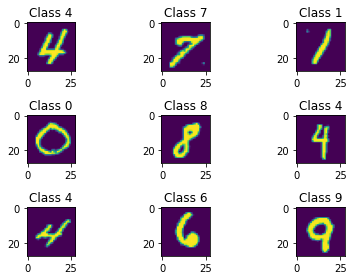

In [179]:
import matplotlib.pyplot as plt
import random

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0,len(X_tr))
    plt.imshow(X_tr[num].reshape(28, 28))#, cmap='gray')
    plt.title('Class {}'.format(y_tr[num]))

plt.tight_layout()

In [143]:
categories = np.concatenate((y_tr, y_test), axis = None)
labels = np.unique(categories)
number_of_classes = np.max(categories)+1

print('Number of classes:', number_of_classes)
print('Classes:', labels)

Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


In [154]:
def all_done(img_indexes) -> bool:
    num = 0
    temp = [len(img_indexes[i]) for i in range(10)]
    for i in range(10):
        if len(img_indexes[i]) == 2:
            num = num + 1
    if num == 10:
        return True
    else:
        return False

In [145]:
index = [i for i in range(len(X_tr))]
random.shuffle(index)

print(index[:50])

[14117, 57640, 17389, 5049, 1077, 53847, 36172, 52756, 44310, 59292, 46103, 7295, 225, 5440, 17989, 10874, 8277, 52195, 52030, 50926, 48563, 23919, 18151, 6157, 9742, 40054, 16008, 1610, 26994, 15985, 41299, 50020, 25808, 52599, 57515, 50094, 27447, 57046, 38867, 46019, 46282, 33523, 48072, 11704, 21452, 29640, 27921, 22060, 14521, 23933]


In [155]:
random_img_index = [[] for i in range(10)]
random_img_index

i = 0
while all_done(random_img_index) == False:
    idx = index[i]
    img_class = y_tr[idx].item(0)
    if len(random_img_index[img_class]) < 2:
        random_img_index[img_class].append(idx)
    i = i+1

print(random_img_index)

[[10874, 9742], [46103, 50094], [8277, 40054], [17389, 1077], [52756, 33523], [5440, 52195], [59292, 6157], [5049, 25808], [57640, 44310], [14117, 53847]]


<Figure size 432x288 with 0 Axes>

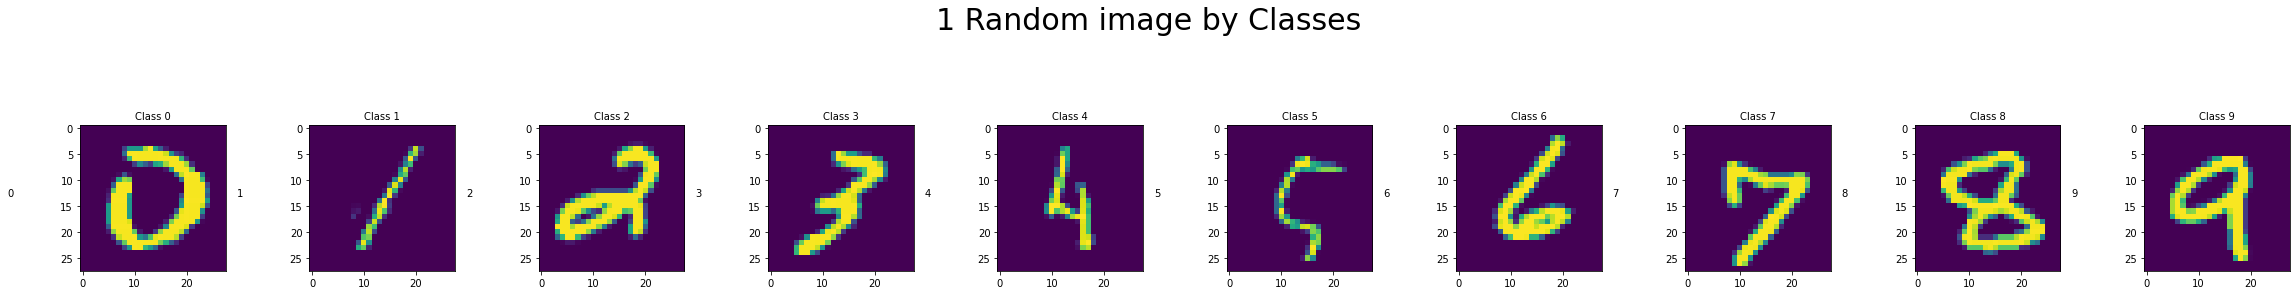

In [173]:
plt.figure()

fig, axis = plt.subplots(ncols = number_of_classes, figsize=(32,4))
fig.suptitle('1 Random image by Classes\n\n', fontsize = 30)

for i in range(number_of_classes):
    axis[i].set_ylabel(labels[i], rotation=0, labelpad = 50)
    axis[i].set_title('Class {}'.format(labels[i]), loc='center', fontsize = 10)
    axis[i].imshow(X_tr[random_img_index[i][0]].reshape(28, 28)) #, interpolation='nearest', aspect='auto')

plt.tight_layout()
plt.show()

## Pixel importance (according to a Random Forest classifier)

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [ ]:
from sklearn.datasets import fetch_openml

#mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
#rnd_clf.fit(mnist["data"], mnist["target"])
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [ ]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

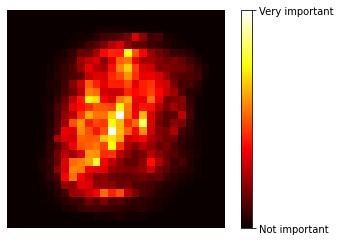

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()

# Image Preparation

## Use StandardScaler()
OBS!!! SVC is sensitive fore SCALING --> Scale! --> StandardScale()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [7]:
X_train_scaled = scaler.fit_transform(X_tr.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0,len(X_train_scaled))
    plt.imshow(X_train_scaled[num].reshape(28, 28))#, cmap='gray')
    plt.title('Class {}'.format(y_tr[num]))

plt.tight_layout()

## PCA

PCA+t-SNE took 320.9s.


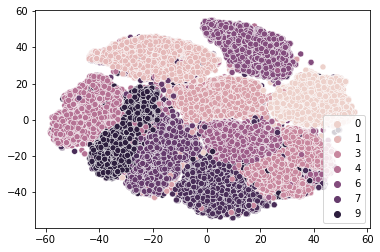

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import time
import seaborn as sns

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_tr)
t1 = time.time()

print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
#plot_digits(X_pca_tsne_reduced, y)
graph = sns.scatterplot(x=X_pca_tsne_reduced[:,0], y=X_pca_tsne_reduced[:,1], hue=y_tr, markers='+')
plt.show()

# SPLIT to Train and Val

In [22]:
X_train_scaled = scaler.fit_transform(X_pca_tsne_reduced.astype(np.float32))

In [44]:
from sklearn.model_selection import train_test_split

ratio = 0.2

#X_train, X_val = train_test_split(X_train_scaled, test_size = ratio, random_state=42)
X_train, X_val = train_test_split(X_pca_tsne_reduced, test_size = ratio, random_state=42)
y_train, y_val = train_test_split(y_tr, test_size = ratio, random_state=42)

In [45]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(48000, 2) (48000,) (12000, 2) (12000,)


# Classifier
## SVM classifier

**automatically use One-vs-the-Rest** , OvR strategy

In [25]:
from sklearn.svm import SVC

# kernel default=’rbf’ - {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
svm_clf = SVC()

In [36]:
t0 = time.time()
svm_clf.fit(X_train, y_train)
t1 = time.time()

print("SVM Classification's FIT took {:.1f}s.".format(t1 - t0))

SVM Classification's FIT took 32.4s.


In [37]:
from sklearn.metrics import accuracy_score
t0 = time.time()
y_pred = svm_clf.predict(X_val)
t1 = time.time()

print("Prediction with SVM took {:.1f}s.".format(t1 - t0))
accuracy_score(y_val, y_pred)

Prediction with SVM took 8.4s.


0.9630833333333333

In [38]:
ml_db.create_log("SVC - PCA+tSNE+StandardScale", str(svm_clf), accuracy_score(y_val, y_pred))

True

### The Thumb rule's next step: Hyperparameter tuning - GridSearch()

In [46]:
from sklearn.model_selection import GridSearchCV

#param_distributions = {"gamma": [x / 1000 for x in range(3, 6)], "C": list(range(3, 6)), "kernel": ['rbf', 'poly']}
#param_distributions = {"gamma": [0.001, 0.003, 0.005, 0.01], "C": [1, 3, 5, 10, 50], "kernel": ['rbf', 'poly']} # 700m
param_distributions = {"gamma": [x / 1000 for x in range(3, 11)], "C": [1, 3, 5, 10, 50], "kernel": ['rbf', 'poly']} # for FeatureReduced X
grid_search_cv = GridSearchCV(svm_clf, param_distributions, cv = 3, verbose = 3)

Do this on a small dataset just to speed up the process :)

In [47]:
grid_search_cv.fit(X_train[:5000], y_train[:5000])

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END ......C=1, gamma=0.003, kernel=rbf;, score=0.948 total time=   0.3s
[CV 2/3] END ......C=1, gamma=0.003, kernel=rbf;, score=0.959 total time=   0.3s
[CV 3/3] END ......C=1, gamma=0.003, kernel=rbf;, score=0.966 total time=   0.3s
[CV 1/3] END .....C=1, gamma=0.003, kernel=poly;, score=0.917 total time=   0.6s
[CV 2/3] END .....C=1, gamma=0.003, kernel=poly;, score=0.921 total time=   0.6s
[CV 3/3] END .....C=1, gamma=0.003, kernel=poly;, score=0.929 total time=   0.6s
[CV 1/3] END ......C=1, gamma=0.004, kernel=rbf;, score=0.950 total time=   0.3s
[CV 2/3] END ......C=1, gamma=0.004, kernel=rbf;, score=0.960 total time=   0.3s
[CV 3/3] END ......C=1, gamma=0.004, kernel=rbf;, score=0.965 total time=   0.4s
[CV 1/3] END .....C=1, gamma=0.004, kernel=poly;, score=0.920 total time=   1.0s
[CV 2/3] END .....C=1, gamma=0.004, kernel=poly;, score=0.924 total time=   1.0s
[CV 3/3] END .....C=1, gamma=0.004, kernel=poly

GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [1, 3, 5, 10, 50],
                         'gamma': [0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01],
                         'kernel': ['rbf', 'poly']},
             verbose=3)

In [48]:
grid_search_cv.best_score_

0.9634013173355725

In [49]:
grid_search_cv.best_estimator_

SVC(C=10, gamma=0.008, probability=True, random_state=42)

In [50]:
from sklearn.metrics import classification_report

y_pred = grid_search_cv.predict(X_val)

print(
     f"Classification report for classifier {grid_search_cv}:\n"
     f"{classification_report(y_val, y_pred)}\n"
)

print("Model's accuracy: {}".format(accuracy_score(y_val, y_pred)))

Classification report for classifier GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [1, 3, 5, 10, 50],
                         'gamma': [0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                                   0.009, 0.01],
                         'kernel': ['rbf', 'poly']},
             verbose=3):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1175
           1       0.96      0.99      0.98      1322
           2       0.97      0.96      0.97      1174
           3       0.96      0.95      0.96      1219
           4       0.98      0.96      0.97      1176
           5       0.96      0.97      0.96      1104
           6       0.98      0.99      0.99      1177
           7       0.95      0.97      0.96      1299
           8       0.98      0.93      0.96      1160
           9       0.94      0.95      0.95      1194

    accuracy                           0.97  

In [51]:
ml_db.create_log("SVC GridSearch (PCA+tSNE)", str(grid_search_cv.best_estimator_), accuracy_score(y_val, y_pred))

True

### Save the best modell

In [33]:
import joblib

# save the model to disk
filename = 'best_model_gridsearch2_svm.sav'
joblib.dump(grid_search_cv.best_estimator_, filename)

['best_model_gridsearch2_svm.sav']

## Bagging (DecisionTree) - OutOfBag (OOB)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

bag_clf = BaggingClassifier(
            DecisionTreeClassifier(),
            n_estimators=500,
            bootstrap=True,
            oob_score=True,
            random_state=40)

X_train_nonscaled, X_val_nonscaled = train_test_split(X_tr, test_size = ratio, random_state=42)

bag_clf.fit(X_train_nonscaled, y_train)
bag_clf.oob_score_

0.9573541666666666

In [ ]:
y_pred = bag_clf.predict(X_val_nonscaled)
accuracy_score(y_val, y_pred)

0.9588333333333333

In [ ]:
# Save the model and prediction's accuracy to DB
ml_db.create_log("Bagging - DecisionTree (OOB)", str(bag_clf), accuracy_score(y_val, y_pred))

import joblib

filename = 'model_{}.sav'.format(bag_clf.__class__.__name__)
joblib.dump(bag_clf, filename)

['model_BaggingClassifier.sav']

## Voting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf', rnd_clf),
                ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train_nonscaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_nonscaled, y_train)
    y_pred = clf.predict(X_val_nonscaled)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))
    ml_db.create_log(str(clf.__class__.__name__), str(clf), accuracy_score(y_val, y_pred))
    filename = 'model_{}.sav'.format(clf.__class__.__name__)
    joblib.dump(clf, filename)

LogisticRegression 0.92225
RandomForestClassifier 0.96925
SVC 0.9775833333333334
VotingClassifier 0.9696666666666667


# Evaluate the Model on the TEST DataSet
## Load in the saved model to TRAIN on the whole DataSet

Note: We only trained the model on 10000 instances. Depends on the time we can retrain the best estimator on the whole training set...

**OBS**: the following cell may take hours to run

In [82]:
import joblib

filename = 'best_model_gridsearch2_svm.sav'
loaded_model = joblib.load(filename)

In [83]:
loaded_model.fit(X_train, y_train)

SVC(C=3, gamma=0.003, kernel='poly')

## Transform and Predict - TEST set

In [84]:
X_test_scaled = scaler.transform(X_test.astype(np.float32))
y_pred = loaded_model.predict(X_test_scaled)

print("Model's accuracy: {}".format(accuracy_score(y_test, y_pred)))

Model's accuracy: 0.9756


In [ ]:
#ml_db.create_log("SVC", "", 0.9733) # 'best_model_gridsearch2_svm.sav'
ml_db.create_log("SVC", str(loaded_model), accuracy_score(y_test, y_pred))

True

Note: Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well. :)

# EXTRA :) CHK my own handwritten digit :)

## SandBox - WIP

Need a a image tranformation for image get the same scale as MNIST

Image's shape: (740, 740)


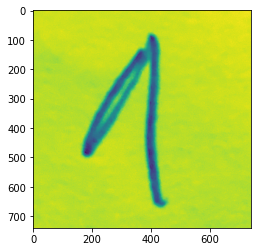

In [190]:
import cv2

my_digit_path = './num1.jpg'
my_digit = cv2.imread(my_digit_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(my_digit) #, cmap = "gray")

print("Image's shape: {}".format(my_digit.shape))

(array([[  0.,   0.,   0., ...,   0., 447., 293.],
        [  0.,   0.,   0., ...,   0., 462., 278.],
        [  0.,   0.,   0., ...,   0., 466., 274.],
        ...,
        [  0.,   0.,   0., ...,   0., 249., 491.],
        [  0.,   0.,   0., ...,   0., 239., 501.],
        [  0.,   0.,   0., ...,   0., 240., 500.]]),
 array([ 40. ,  52.5,  65. ,  77.5,  90. , 102.5, 115. , 127.5, 140. ,
        152.5, 165. ]),
 <a list of 740 BarContainer objects>)

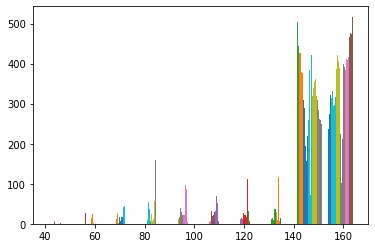

In [ ]:
plt.hist(my_digit)

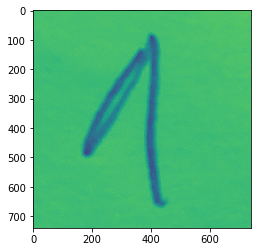

In [191]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
my_digit = cv2.filter2D(my_digit, -1, sharpen_kernel)
plt.imshow(my_digit)

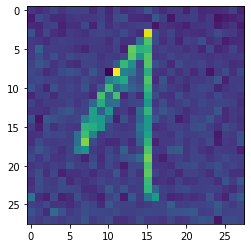

In [192]:
my_digit = cv2.resize(my_digit, (28, 28), interpolation = cv2.INTER_LINEAR)
my_digit = cv2.bitwise_not(my_digit)
plt.imshow(my_digit)

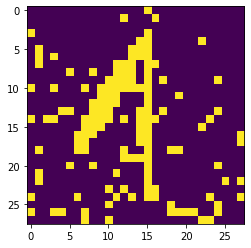

In [189]:
#Convert a grayscale image to black and white using binary thresholding 
(thresh, my_digit) = cv2.threshold(my_digit, 110, 255, cv2.THRESH_BINARY)

#display all the images
plt.imshow(my_digit)

In [193]:
def transfer_colour(img):
    #img[img < 100] = 0
    #img[img != 0] = 1
    img[img < 110] = 0
    img[img > 185] = 255
    return img

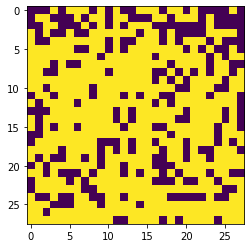

In [194]:
my_digit = transfer_colour(my_digit)

plt.imshow(my_digit)

In [57]:
def get_bounding_box(img):
    col_sum = np.where(np.sum(img, axis = 0)>0)
    row_sum = np.where(np.sum(img, axis = 1)>0)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    bbox = [x1, y1, x2, y2, x2 - x1, y2 - y1]
    return bbox

In [58]:
def add_padding(img, pad_l, pad_t, pad_r, pad_b):
    height, width = img.shape
    #Adding padding to the left side.
    pad_left = np.zeros((height, pad_l), dtype = np.int)
    img = np.concatenate((pad_left, img), axis = 1)

    #Adding padding to the top.
    pad_up = np.zeros((pad_t, pad_l + width))
    img = np.concatenate((pad_up, img), axis = 0)

    #Adding padding to the right.
    pad_right = np.zeros((height + pad_t, pad_r))
    img = np.concatenate((img, pad_right), axis = 1)

    #Adding padding to the bottom
    pad_bottom = np.zeros((pad_b, pad_l + width + pad_r))
    img = np.concatenate((img, pad_bottom), axis = 0)

    return img

In [121]:
bbox = get_bounding_box(my_digit)
bbox

print(bbox[1], bbox[3], bbox[0], bbox[2])
print("Height: {}".format(bbox[5]), "Width: {}".format(bbox[4]))

3 24 6 16
Height: 21 Width: 10


In [122]:
padd_x = int((28 - bbox[4]) / 2)
padd_y = int((28 - bbox[5]) / 2)

print(padd_x, padd_y)

9 3


Image's shape: (28, 28)


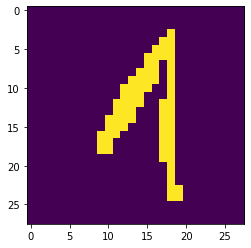

In [129]:
cropped_image = my_digit[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]
plt.imshow(cropped_image)#, cmap = "gray")

#cropped_image = img[y1:y2, x1:x2]
padded_image = add_padding(cropped_image, padd_x, padd_y, 27 - bbox[4] - padd_x, 27 - bbox[5] - padd_y)

plt.imshow(padded_image)#, cmap = "gray")

print("Image's shape: {}".format(padded_image.shape))

In [131]:
img_to_test = np.reshape(my_digit, (1, 28*28))
print("Image's shape: {}".format(img_to_test.shape))

Image's shape: (1, 784)


In [132]:
own_pred = loaded_model.predict(img_to_test)
own_pred[0]

9

In [47]:
import cv2
import numpy as np

my_digit_test = np.empty((1, 28*28))
print(type(my_digit_test))
print(my_digit_test.shape)
#my_digit_test

<class 'numpy.ndarray'>
(1, 784)


In [48]:
my_digit = './num{}.jpg'.format(1)
image_to_show = cv2.imread(my_digit, cv2.IMREAD_GRAYSCALE)
imageprep_2 = cv2.resize(image_to_show, (28, 28), interpolation = cv2.INTER_LINEAR)
imageprep_2 = cv2.bitwise_not(imageprep_2)
img_to_test = np.reshape(imageprep_2, (1, 28*28))

print(type(img_to_test))
print(img_to_test.shape)
#img_to_test

<class 'numpy.ndarray'>
(1, 784)


In [49]:
np.append(my_digit_test, img_to_test, axis = 0)
print(type(my_digit_test))
print(my_digit_test.shape)
my_digit_test

<class 'numpy.ndarray'>
(1, 784)


array([[ 8.54742377e-42,  1.30976611e-31, -6.45776266e-32,
         8.53987967e-31,  4.39655940e-50, -7.12427633e-60,
        -1.50814553e-21, -4.08326049e-26, -1.30081845e-21,
        -8.25268989e-18,  3.93794991e-19,  1.67088754e-13,
        -1.45051950e-26,  2.57992311e-47,  1.13360075e-20,
        -1.34789902e-08,  3.85395920e-55,  1.71852516e-24,
         8.32094103e-22,  2.27926799e-49,  1.56118868e-20,
         2.66779219e-34, -1.10682072e-60,  2.87605611e-31,
        -8.90015150e-28,  1.18148892e-32,  7.41360723e-25,
        -3.53610902e-26,  2.03388173e-32,  1.04676745e-23,
         3.82624864e-31, -9.96096442e-34,  3.51828544e-41,
        -2.31031765e-40,  1.22815456e-52,  4.47477604e-13,
         4.45610991e-41, -1.03891886e-26,  8.20098081e-32,
         4.39766374e-25, -4.82939269e-22,  5.19108651e-23,
         1.36456321e-33, -3.98135096e-46, -7.19998895e-23,
         4.84089573e-15,  1.44984266e-32,  1.09012229e-23,
         3.07019108e-43, -5.96987491e-30, -4.60402175e-1

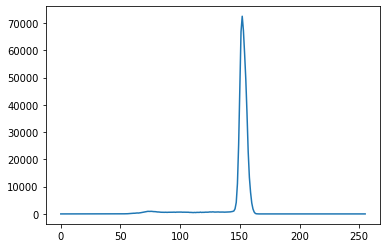

In [ ]:
# importing required libraries of opencv
import cv2

# importing library for plotting
from matplotlib import pyplot as plt

# reads an input image
img = cv2.imread(my_digit_path,0)

# find frequency of pixels in range 0-255
histr = cv2.calcHist([img],[0],None,[256],[0,256])

# show the plotting graph of an image
plt.plot(histr)
plt.show()

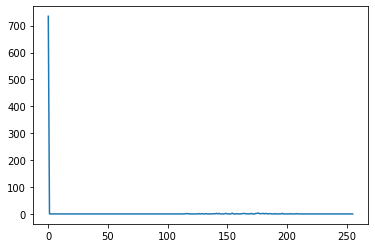

In [ ]:
# find frequency of pixels in range 0-255
histr = cv2.calcHist([imageprep_2],[0],None,[256],[0,256])

# show the plotting graph of an image
plt.plot(histr)
plt.show()

### Bara Andreas tips

Image's shape: (28, 28)


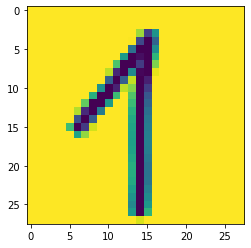

In [ ]:
import cv2

my_digit_path = './My_digits/set_paint/num1.png'
my_digit = cv2.imread(my_digit_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(my_digit)

print("Image's shape: {}".format(my_digit.shape))

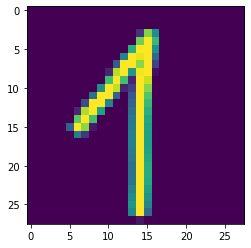

In [ ]:
my_digit = cv2.resize(my_digit, (28, 28), interpolation = cv2.INTER_LINEAR)
my_digit = cv2.bitwise_not(my_digit)
plt.imshow(my_digit)

In [ ]:
def transfer_colour(img):
    img[img < 100] = 0
    img[img != 0] = 1
    return img

In [ ]:
my_digit = transfer_colour(my_digit)
plt.imshow(my_digit)

In [ ]:
img_to_test = np.reshape(my_digit, (1, 28*28))
print("Image's shape: {}".format(img_to_test.shape))

Image's shape: (1, 784)


In [ ]:
own_pred = loaded_model.predict(img_to_test)
own_pred[0]

NameError: name 'loaded_model' is not defined

### Picikevel

Image's shape: (28, 28)


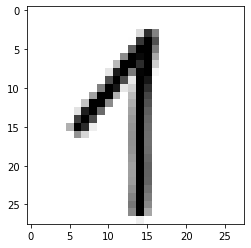

In [84]:
import cv2

my_digit_path = './My_digits/set_paint/num1.png'
my_digit = cv2.imread(my_digit_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(my_digit, cmap='gray')

print("Image's shape: {}".format(my_digit.shape))

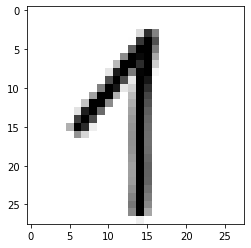

In [57]:
my_digit = cv2.resize(my_digit, (28, 28), interpolation = cv2.INTER_LINEAR)
#my_digit = cv2.bitwise_not(my_digit)
plt.imshow(my_digit, cmap='gray')

## Distribution

In [73]:
act_digit = my_digit
np.histogram(act_digit, bins=255)

(array([ 37,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,
          0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   1,   0,   1,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   1,
          1,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   1,   1,   1,   0,   1,   0,   0,   2,   0,
          0,   0,   0,   2,   0,   1,   1,   1,   1,   0,   0,   0,   0,
          0,   0,   1,   0,   1,   0,   0,   2,   0,   0,   0,   0,   1,
          0,   2,   0,   0,   0,   0,   0,   2,   0,   1,   1,   0,   0,
          0,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   2,   0,
          1,   0,   0,   1,   1,   1,   1,   0,   0,   0,   1,   1,   0,
          0,   0,   0,   0,   0,   1,   1,   1,   0

(array([[ 0.,  0.,  0., ...,  0.,  0., 28.],
        [ 0.,  0.,  0., ...,  0.,  0., 28.],
        [ 0.,  0.,  0., ...,  0.,  0., 28.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0., 28.],
        [ 0.,  0.,  0., ...,  0.,  0., 28.],
        [ 0.,  0.,  0., ...,  0.,  0., 28.]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105.,

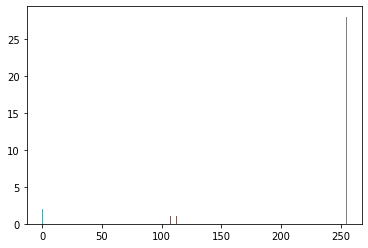

In [74]:
plt.hist(act_digit, bins=255)

In [76]:
numbers_of_colours = np.histogram(act_digit, bins=255)[0] # Y - Colour's distribution
numbers_of_colours

array([ 37,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,
         0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   1,   0,   1,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   1,
         1,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   1,   1,   1,   1,   0,   1,   0,   0,   2,   0,
         0,   0,   0,   2,   0,   1,   1,   1,   1,   0,   0,   0,   0,
         0,   0,   1,   0,   1,   0,   0,   2,   0,   0,   0,   0,   1,
         0,   2,   0,   0,   0,   0,   0,   2,   0,   1,   1,   0,   0,
         0,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   2,   0,
         1,   0,   0,   1,   1,   1,   1,   0,   0,   0,   1,   1,   0,
         0,   0,   0,   0,   0,   1,   1,   1,   0,   0,   0,   

In [77]:
colours = np.histogram(act_digit, bins=255)[1] # X - Colour's number on the Black - White spectrum 0..255
colours

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [79]:
max_dist = numbers_of_colours.max()
max_dist

673

In [80]:
max_colour_value = 0
for i in range(len(numbers_of_colours)):
    if numbers_of_colours[i] == max_dist:
        max_colour_value = i

max_colour_value

254

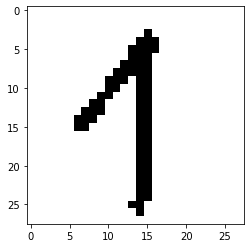

In [92]:
(thresh, img) = cv2.threshold(my_digit, max_colour_value/2, max_colour_value, cv2.THRESH_BINARY)
plt.imshow(img, cmap='gray')

In [82]:
def transfer_colour(img, min, max):
    img[img < min] = 0
    #img[img >= min and img <=max] = ((img - min) / (max - min)) * 255
    xdist = max - min # indent as index from 0 to 256, for the above picture: indentRight: 235, indentLeft: 15
    alpha = 256.0 / xdist
    beta = -(min * alpha)
    img[img >= min and img <=max] = beta
    img[img > max] = 255
    
    return img

In [83]:
my_digit = transfer_colour(my_digit, max_colour_value/2, max_colour_value)
plt.imshow(my_digit)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
type(my_digit)

numpy.ndarray

In [ ]:
my_digit.shape

(28, 28)

In [ ]:
gaus_thres = cv2.adaptiveThreshold(my_digit, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 7, 7)
plt.imshow(gaus_thres)

In [ ]:
gaus_thres = cv2.adaptiveThreshold(my_digit, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_OTSU)
plt.imshow(gaus_thres)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'adaptiveThreshold'
> Overload resolution failed:
>  - adaptiveThreshold() missing required argument 'blockSize' (pos 5)
>  - adaptiveThreshold() missing required argument 'blockSize' (pos 5)


In [ ]:
img_to_test = np.reshape(gaus_thres, (1, 28*28))
print("Image's shape: {}".format(img_to_test.shape))

Image's shape: (1, 784)


In [ ]:
own_pred = loaded_model.predict(img_to_test)
own_pred[0]

NameError: name 'loaded_model' is not defined

## Predict All my digit
!!! Could be run only this part of the code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import joblib
import cv2
from sklearn.metrics import accuracy_score

### Load in best trained model and MNIST Data

In [2]:
# LOAD Dataset - MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)
train_N = 60000 # Choose a suitable N
X_tr = X[:train_N]
y_tr = y[:train_N]

# LOAD best taring Model
filename = 'best_model_gridsearch_svm.sav'
loaded_model = joblib.load(filename)

In [3]:
# Initialization
labels = np.unique(y_tr)
number_of_classes = np.max(y_tr)+1

## Use StandardScaler()
scaler = StandardScaler()

In [4]:
# TRAIN the Model
X_train_scaled = scaler.fit_transform(X_tr.astype(np.float32))
loaded_model.fit(X_train_scaled, y_tr)

### Load in and prepare my digits

#### Function definitions

In [ ]:
def get_bounding_box(img):
    col_sum = np.where(np.sum(img, axis = 0)>0)
    row_sum = np.where(np.sum(img, axis = 1)>0)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    bbox = [x1, y1, x2, y2, x2 - x1, y2 - y1]
    
    return bbox

In [ ]:
def add_padding(img, pad_l, pad_t, pad_r, pad_b):
    height, width = img.shape
    #Adding padding to the left side.
    pad_left = np.zeros((height, pad_l), dtype = np.int)
    img = np.concatenate((pad_left, img), axis = 1)

    #Adding padding to the top.
    pad_up = np.zeros((pad_t, pad_l + width))
    img = np.concatenate((pad_up, img), axis = 0)

    #Adding padding to the right.
    pad_right = np.zeros((height + pad_t, pad_r))
    img = np.concatenate((img, pad_right), axis = 1)

    #Adding padding to the bottom
    pad_bottom = np.zeros((pad_b, pad_l + width + pad_r))
    img = np.concatenate((img, pad_bottom), axis = 0)

    return img

In [ ]:
def load_and_prep_digit(img_path):
    # Read in
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Transform
    img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_LINEAR)
    img = cv2.bitwise_not(img)
    (thresh, img) = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
    # Centering
    bbox = get_bounding_box(img)
    padd_x = int((28 - bbox[4]) / 2)
    padd_y = int((28 - bbox[5]) / 2)
    cropped_image = img[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]
    padded_image = add_padding(cropped_image,
                                padd_x, padd_y, 
                                27 - bbox[4] - padd_x, 27 - bbox[5] - padd_y)
    
    return img

In [ ]:
cv2.boundingRect(image)

#### Load in my digits

In [ ]:
my_digit_test = np.empty((1, 28*28))

for i in range(0, 10):
    #my_digit_path = './num{}.jpg'.format(i)
    my_digit_path = './My_digits/set_merged/num{}.jpg'.format(i)
    #my_digit = cv2.imread(my_digit_path, cv2.IMREAD_GRAYSCALE)
    my_digit = load_and_prep_digit(my_digit_path)
    img_to_test = np.reshape(my_digit, (1, 28*28))
    my_digit_test = np.vstack([my_digit_test, img_to_test])

my_digit_test = np.delete(my_digit_test, 0, axis=0)

print("Test set's shape: {}".format(my_digit_test.shape))

Test set's shape: (10, 784)


<Figure size 432x288 with 0 Axes>

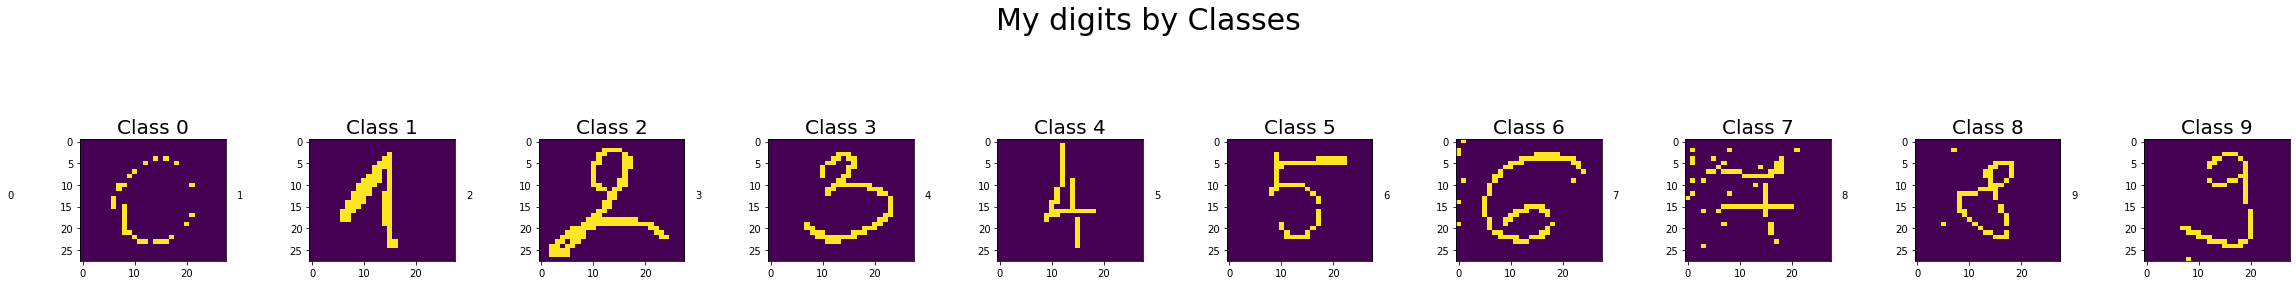

In [ ]:
plt.figure()

fig, axis = plt.subplots(ncols = number_of_classes, figsize=(32,4))
fig.suptitle('My digits by Classes\n\n', fontsize = 30)

for i in range(number_of_classes):
    axis[i].set_ylabel(labels[i], rotation=0, labelpad = 50)
    axis[i].set_title('Class {}'.format(labels[i]), loc='center', fontsize = 20)
    axis[i].imshow(my_digit_test[i].reshape(28, 28), interpolation='nearest', aspect='auto')

plt.tight_layout()
plt.show()

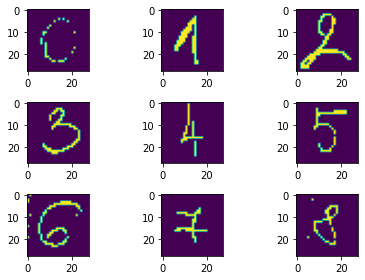

In [ ]:
for i in range(len(my_digit_test)-1):
    plt.subplot(3,3,i+1)
    plt.imshow(my_digit_test[i].reshape(28, 28))#, cmap='gray')
    #plt.title('Class {}'.format(own_pred[num]))

plt.tight_layout()

### ShowTime - See my digits :)

### Predict and Evaluate my own digits

In [ ]:
own_pred = loaded_model.predict(my_digit_test)
own_pred

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
print("Model's accuracy: {}".format(accuracy_score(labels, own_pred)))

Model's accuracy: 1.0


set_1 - 0.6 - FEL: 1,6,8,9

<Figure size 432x288 with 0 Axes>

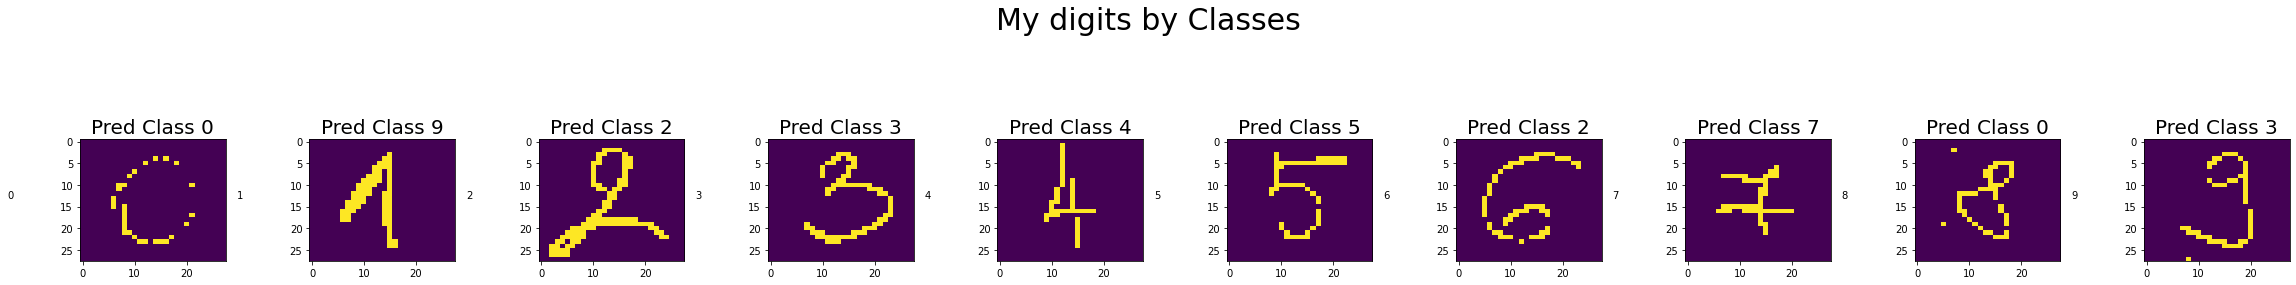

In [ ]:
plt.figure()

fig, axis = plt.subplots(ncols = number_of_classes, figsize=(32,4))
fig.suptitle('My digits by Classes\n\n', fontsize = 30)

for i in range(number_of_classes):
    axis[i].set_ylabel(labels[i], rotation=0, labelpad = 50)
    axis[i].set_title('Pred Class {}'.format(own_pred[i]), loc='center', fontsize = 20)
    axis[i].imshow(my_digit_test[i].reshape(28, 28), interpolation='nearest', aspect='auto')

plt.tight_layout()
plt.show()

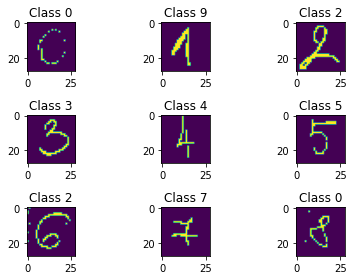

In [ ]:
for i in range(len(my_digit_test)-1):
    plt.subplot(3,3,i+1)
    plt.imshow(my_digit_test[i].reshape(28, 28))#, cmap='gray')
    plt.title('Class {}'.format(own_pred[i]))

plt.tight_layout()

# ToDo - Understand it - Centering the image !!!

# Number of images of digits.
ndigits = digits.shape[0]
# Reshape them to rectangular
images.images = digits.reshape([ndigits,28,28])

# Calculate the sum of pixel values for each
image.imagesums = np.sum(np.sum(images, axis=1), axis=1)

# Create mesh of x and y coordinates.
indices = np.arange(28)
X, Y = np.meshgrid(indices, indices)

# Calculate centroid coordinates for each image.
#centroidx = numpy.array([numpy.sum(images[i] * X) for i in xrange(ndigits)]) / imagesums
#centroidy = numpy.array([numpy.sum(images[i] * Y) for i in xrange(ndigits)]) / imagesums

# This code is faster and yields the same result.
centroidx = np.sum(np.sum(images*X,axis=1),axis=1)/imagesums;
centroidy = np.sum(np.sum(images*Y,axis=1),axis=1)/imagesums;

# What range do centroid coordinates span?
print np.min(centroidx), np.max(centroidx);
print np.min(centroidy), np.max(centroidy);